In [7]:
from os.path import join
import copy

import numpy as np
import pandas as pd
import ast

from sklearn.metrics import fbeta_score
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from tqdm import tqdm_notebook
from joblib import Parallel, delayed

# data_dir = "D:/MLiP/data/"

In [2]:
def labels_one_hot(labels):
    
    onehot_label = [0.] * 228
    for label in labels:
        onehot_label[int(label) - 1] = 1.
    
    return onehot_label

In [3]:
predictions_df = pd.DataFrame.from_csv('validation_prediction.csv')
predictions = predictions_df.values
print(predictions.shape)

(9897, 228)


In [4]:
ground_truth = pd.DataFrame.from_csv(join('/home/ankur/kaggle/fashion/machinelearninginpractice/fashion_challenge/', "csv/valid_labels.csv"))
labels_gt = []
for i in range(9897):
    row = ground_truth.iloc[i, :]
    label = labels_one_hot(ast.literal_eval(row['labelId']))
    labels_gt.append(label)
labels_gt = np.array(labels_gt)
print(labels_gt.shape)

(9897, 228)


In [10]:
true = labels_gt
pred = predictions

def compute_f1(j, best_threshold, new_threshold):
    temp_threshold = copy.copy(best_threshold)
    temp_threshold[j] = new_threshold
    
    return fbeta_score(true, np.where(pred > temp_threshold, 1, 0), beta=1, average='samples')

def get_optimal_thresholds(true, pred, max_epochs=10, n_jobs=-1):
    # Assert true and pred have same shape
    dims = true.shape
    assert(dims == pred.shape)

    best_f1 = 0.
    best_threshold = np.ones(228) * 0.5

    for i in range(max_epochs):
        epoch_threshold = copy.copy(best_threshold)
        for j in tqdm_notebook(range(dims[1])):
            proposed_values = np.linspace(0.25, 0.75, 10)
            f1s = Parallel(n_jobs=n_jobs)(delayed(compute_f1)(j, epoch_threshold, k) for k in proposed_values)

            epoch_threshold[j] = proposed_values[np.argmax(f1s)]
            print("Fine tuned label: ", j+1, " F1 score improved to: ", max(f1s))
        
        if all(best_threshold == epoch_threshold):
            print("Converged after ", i+1, " epochs.")
            return best_f1, best_threshold
        else:
            best_threshold = epoch_threshold

In [11]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

score, thresh = get_optimal_thresholds(labels_gt, predictions, max_epochs=10)

Fine tuned label:  1  F1 score improved to:  0.463548825502
Fine tuned label:  2  F1 score improved to:  0.463548825502
Fine tuned label:  3  F1 score improved to:  0.463548825502
Fine tuned label:  4  F1 score improved to:  0.463652901705
Fine tuned label:  5  F1 score improved to:  0.463688097163
Fine tuned label:  6  F1 score improved to:  0.463762206027
Fine tuned label:  7  F1 score improved to:  0.463773500397
Fine tuned label:  8  F1 score improved to:  0.463773500397
Fine tuned label:  9  F1 score improved to:  0.463773500397
Fine tuned label:  10  F1 score improved to:  0.463796110908
Fine tuned label:  11  F1 score improved to:  0.463805064827
Fine tuned label:  12  F1 score improved to:  0.463813577415
Fine tuned label:  13  F1 score improved to:  0.463818870024
Fine tuned label:  14  F1 score improved to:  0.463855150024
Fine tuned label:  15  F1 score improved to:  0.464467269035
Fine tuned label:  16  F1 score improved to:  0.464467269035
Fine tuned label:  17  F1 score i

In [12]:
thresh

array([ 0.25      ,  0.47222222,  0.36111111,  0.30555556,  0.30555556,
        0.25      ,  0.52777778,  0.25      ,  0.30555556,  0.25      ,
        0.47222222,  0.25      ,  0.41666667,  0.25      ,  0.25      ,
        0.25      ,  0.25      ,  0.30555556,  0.30555556,  0.30555556,
        0.25      ,  0.25      ,  0.25      ,  0.25      ,  0.25      ,
        0.25      ,  0.47222222,  0.30555556,  0.25      ,  0.25      ,
        0.30555556,  0.25      ,  0.30555556,  0.30555556,  0.25      ,
        0.25      ,  0.25      ,  0.25      ,  0.25      ,  0.25      ,
        0.25      ,  0.63888889,  0.58333333,  0.25      ,  0.25      ,
        0.25      ,  0.25      ,  0.25      ,  0.25      ,  0.25      ,
        0.25      ,  0.25      ,  0.25      ,  0.25      ,  0.25      ,
        0.25      ,  0.25      ,  0.25      ,  0.25      ,  0.30555556,
        0.63888889,  0.30555556,  0.52777778,  0.25      ,  0.41666667,
        0.25      ,  0.25      ,  0.25      ,  0.47222222,  0.25

In [30]:
fbeta_score(labels_gt, np.where(predictions > np.ones(228)*0.5, 1, 0), beta=1, average='samples')

/home/ankur/miniconda3/envs/mlip/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


0.46354882550163728

In [12]:
def get_optimal_thresholds_svm(true, pred, epochs=10):
    
    # Assert true and pred have same shape
    dims = true.shape
    assert(dims == pred.shape)

    # Initialize values to be filled in, thresholds start at 0.1
    thresholds = []
    temp_threshold = np.ones(dims[1])*0.5
    
    for j in range(dims[1]):
        clf = SGDClassifier()
        clf.fit(pred[:, j][:, np.newaxis], true[:, j])
        thresholds.append(clf.intercept_[0])
        temp_threshold[j] = clf.intercept_[0]
        print("Found threshold for label: ", j+1, ": ", clf.intercept_)
        
        thresholded_pred = np.where(pred > temp_threshold, 1, 0)
        # Calculate 
        f1 = sum([fbeta_score(true[x], thresholded_pred[x], beta=1) for x in range(dims[0])]) / dims[0]
        print("Fine tuned label: ", j+1, "got f1: ", f1)

    return f1, thresholds

get_optimal_thresholds_svm(labels_gt, predictions)

Found threshold for label:  1 :  [-1.03419684]
Fine tuned label:  1 got f1:  0.425484297523
Found threshold for label:  2 :  [-1.09722878]
Fine tuned label:  2 got f1:  0.397008609427
Found threshold for label:  3 :  [-1.17896584]
Fine tuned label:  3 got f1:  0.369480639288
Found threshold for label:  4 :  [-1.28182419]
Fine tuned label:  4 got f1:  0.346037809889
Found threshold for label:  5 :  [-1.09416227]
Fine tuned label:  5 got f1:  0.32717214141
Found threshold for label:  6 :  [-2.13264857]
Fine tuned label:  6 got f1:  0.308537812796
Found threshold for label:  7 :  [-1.12968115]
Fine tuned label:  7 got f1:  0.294067429838
Found threshold for label:  8 :  [-1.07681713]
Fine tuned label:  8 got f1:  0.279039659967
Found threshold for label:  9 :  [-1.05547059]
Fine tuned label:  9 got f1:  0.268452538894
Found threshold for label:  10 :  [-1.20962614]
Fine tuned label:  10 got f1:  0.256794198699
Found threshold for label:  11 :  [-1.28591383]
Fine tuned label:  11 got f1:  

ValueError: The number of class labels must be greater than one.

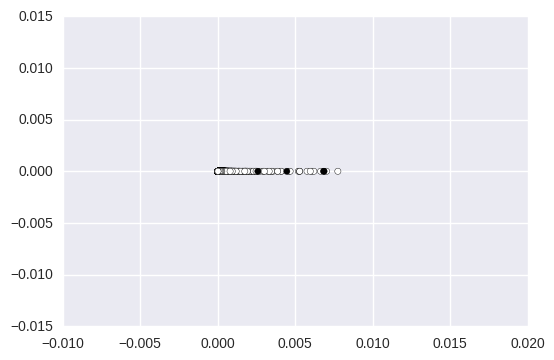

In [16]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.scatter(predictions[:, 0], [0]*predictions.shape[0], c=labels_gt[:, 0])

In [65]:
print(np.linspace(0.1, 1, 10))

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
